<a href="https://colab.research.google.com/github/mlzzi/python-machine-learning--transfer-learning/blob/main/Transfer_Learning_Desafio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANDO AS DEPENDÊNCIAS

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

BAIXAR E LIMPAR O DATASET E LIMITAR CADA CLASSE COM 150 IMAGENS

In [2]:
import os
import shutil
import zipfile
import requests
from PIL import Image

# Função para baixar o dataset
def download_dataset(url, output_path):
    response = requests.get(url)
    with open(output_path, 'wb') as f:
        f.write(response.content)

# Função para extrair o arquivo ZIP
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Função para limpar imagens quebradas e limitar a quantidade de imagens por categoria
def clean_and_limit_images(data_dir, categories, limit):
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)
        valid_images = []

        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Verifica se a imagem está quebrada
                valid_images.append(img_name)
            except (IOError, SyntaxError):
                os.remove(img_path)  # Remove a imagem quebrada

        # Limita a quantidade de imagens por categoria
        for img_name in valid_images[limit:]:
            os.remove(os.path.join(category_path, img_name))

# URL do dataset e caminhos dos arquivos
dataset_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
zip_path = "kagglecatsanddogs_5340.zip"
data_dir = "/content/cats_and_dogs_data/PetImages"
categories = ["Cat", "Dog"]
limit = 150

# Baixar o dataset
print("Baixando Cats and Dogs Dataset")
download_dataset(dataset_url, zip_path)

# Extrair os arquivos
print("Extraindo arquivos...")
extract_zip(zip_path, "/content/cats_and_dogs_data")

# Limpar imagens quebradas e limitar a quantidade de imagens por categoria
print("Limpando imagens quebradas e limitando a quantidade de imagens por categoria")
clean_and_limit_images(data_dir, categories, limit)

# Verificar o conteúdo extraído
print("Conteúdo extraído:")
for category in categories:
    print(f"{category}: {len(os.listdir(os.path.join(data_dir, category)))} imagens")

Baixando Cats and Dogs Dataset
Extraindo arquivos...
Limpando imagens quebradas e limitando a quantidade de imagens por categoria


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Conteúdo extraído:
Cat: 150 imagens
Dog: 150 imagens


CARREGAR AS IMAGENS NA PASTA ROOT

In [3]:
import os

# Diretório raiz onde as imagens estão localizadas
root = '/content/cats_and_dogs_data/PetImages'

exclude = []

train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

categories = [c for c in categories if c not in exclude]

# Mostrar as categorias
print(categories)

['/content/cats_and_dogs_data/PetImages/Cat', '/content/cats_and_dogs_data/PetImages/Dog']


FUNÇÃO PARA PRÉ-PROCESSAR OS DADOS EM IMAGEM E VETOR DE INPUT

In [4]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

# Função auxiliar para carregar a imagem e retornar a imagem e o vetor de entrada
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))

    x = image.img_to_array(img)

    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)

    return img, x

CARREGAR OS DADOS DA PASTA ROOT

In [5]:
from PIL import UnidentifiedImageError
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

# Função auxiliar para carregar a imagem e retornar a imagem e o vetor de entrada
def get_image(path):
    try:
        img = image.load_img(path, target_size=(224, 224))

        x = image.img_to_array(img)

        x = np.expand_dims(x, axis=0)

        x = preprocess_input(x)

        return img, x
    except UnidentifiedImageError:
        # Print the path of the problematic image
        print(f"Skipping invalid image: {path}")
        # Return None to signal that the image loading failed
        return None, None

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        # Check if the image loading was successful
        if img is not None and x is not None:
            data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

DEIXAR OS DADOS EM FORMA ALEATÓRIA

In [6]:
random.shuffle(data)

CRIAR TREINAMENTO / VALIDAÇÃO / TESTE SPLIT (70%, 15%, 15%)

In [7]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

SEPARAR DADOS POR RÓTULOS

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]


PRÉ-PROCESSAR OS DADOS, CERTIFICANDO-SE DE QUE SEJAM FLOAT32 E NORMALIZADOS ENTRE 0 E 1

In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(45, 2)


IMPRIMIR E SUMARIZAR O QUE FOI FEITO

In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 300 images from 2 categories
train / validation / test split: 210, 45, 45
training data shape:  (210, 224, 224, 3)
training labels shape:  (210, 2)


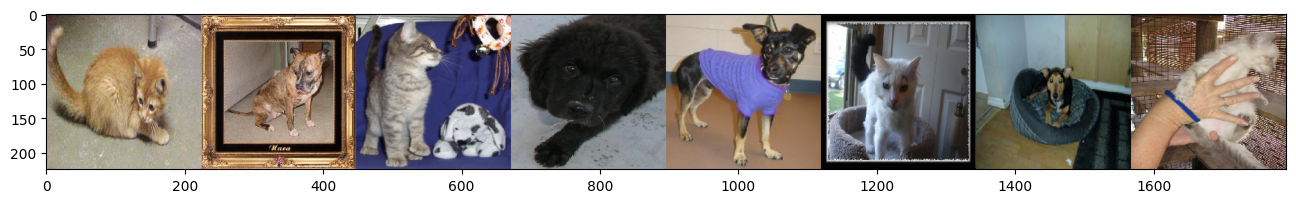

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

TREINAMENTO NEURAL DO INÍCIO

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compilar o modelo usando a função de perda categorical_crossentropy e o otimizador adam
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Treinar o modelo com os dados de treinamento (x_train, y_train)
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.4541 - loss: 0.7076 - val_accuracy: 0.3111 - val_loss: 0.7702
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step - accuracy: 0.5280 - loss: 0.7051 - val_accuracy: 0.3111 - val_loss: 0.7078
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.5742 - loss: 0.6861 - val_accuracy: 0.6444 - val_loss: 0.6893
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.5093 - loss: 0.6925 - val_accuracy: 0.6000 - val_loss: 0.6896
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - accuracy: 0.6600 - loss: 0.6775 - val_accuracy: 0.5556 - val_loss: 0.6907
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.6190 - loss: 0.6748 - val_accuracy: 0.5111 - val_loss: 0.6965
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step - accuracy: 0.6332 - loss: 0.6611 - val_accuracy: 0.4889 - val_loss: 0.7049
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.6196 - loss: 0.6516 - val_accuracy: 0.6444 - val_loss: 0.6669
Epoch 9/

PLOTAR A VALIDAÇÃO LOSS E PRECISÃO DA VALIDAÇÃO ATRAVÉS DO TEMPO

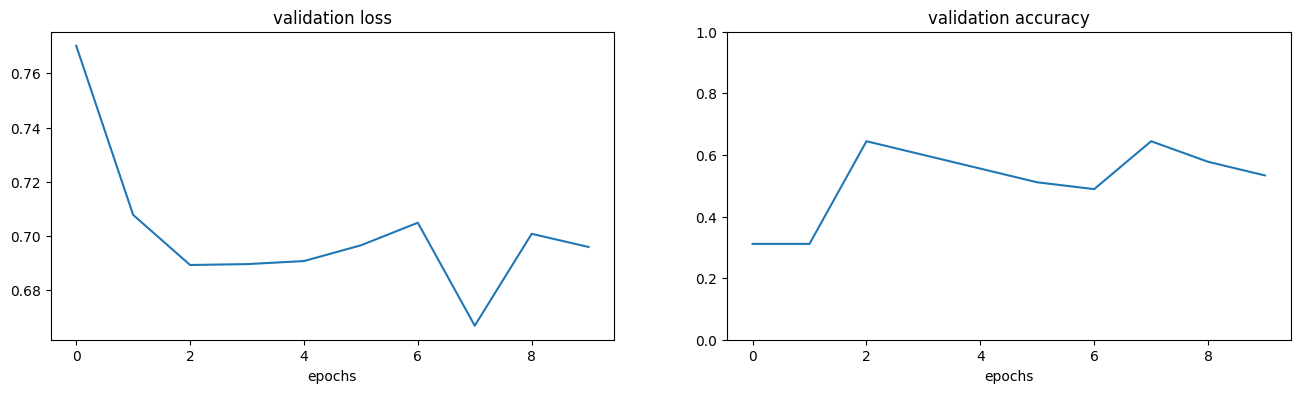

In [14]:
# Criar uma figura com um tamanho específico para o gráfico (16x4)
fig = plt.figure(figsize=(16,4))

# Adicionar um subplot para o gráfico de perda de validação
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

# Adicionar um segundo subplot para o gráfico de acurácia de validação
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

# Exibir os gráficos
plt.show()


In [15]:
# Avaliar o modelo no conjunto de dados de teste
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Imprimir a perda (loss) no conjunto de teste
print('Test loss:', loss)

# Imprimir a acurácia (accuracy) no conjunto de teste
print('Test accuracy:', accuracy)

Test loss: 0.7618399858474731
Test accuracy: 0.3777777850627899


AQUI COMEÇA O TRANSFER LEARNING PARTINDO DE UM MODELO JÁ PRONTO - VGG16

In [16]:
# Carregando o modelo VGG16 com pesos pré-treinados no ImageNet
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

# Exibindo um resumo da arquitetura do modelo VGG16
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Fazendo referência à camada de entrada do modelo VGG
inp = vgg.input

# Criando uma nova camada de classificação com softmax
new_classification_layer = Dense(num_classes, activation='softmax')

# Conectando a nova camada ao penúltimo output da rede VGG (a penúltima camada)
out = new_classification_layer(vgg.layers[-2].output)

# Criando um novo modelo entre a camada de entrada do VGG e a nossa nova camada de saída
model_new = Model(inp, out)

In [18]:
# Congelando todas as camadas (exceto a última) para que seus pesos não sejam ajustados durante o treinamento
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Garantindo que a última camada seja treinável
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

# Compilando o modelo com a função de perda 'categorical_crossentropy' e o otimizador 'adam'
model_new.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Exibindo a arquitetura do modelo
model_new.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [25]:
# Treinando o modelo model_new com os dados de treinamento e validação
history2 = model_new.fit(
    x_train,  # Dados de entrada para o treinamento
    y_train,  # Rótulos das classes para os dados de entrada
    batch_size=128,  # Número de amostras por atualização de gradiente
    epochs=10,  # Número de épocas (iterações sobre o conjunto de dados)
    validation_data=(x_val, y_val)  # Dados de validação para acompanhar a performance durante o treinamento
)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 178s 96s/step - accuracy: 0.8449 - loss: 0.4900 - val_accuracy: 0.5333 - val_loss: 0.6339
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 169s 81s/step - accuracy: 0.7383 - loss: 0.4834 - val_accuracy: 0.5333 - val_loss: 0.7087
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 209s 92s/step - accuracy: 0.7195 - loss: 0.4868 - val_accuracy: 0.7333 - val_loss: 0.5267
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 189s 82s/step - accuracy: 0.8738 - loss: 0.4297 - val_accuracy: 0.8444 - val_loss: 0.4365
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 211s 80s/step - accuracy: 0.8475 - loss: 0.4456 - val_accuracy: 0.8444 - val_loss: 0.4394
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 197s 82s/step - accuracy: 0.8885 - loss: 0.4139 - val_accuracy: 0.7333 - val_loss: 0.5252
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 211s 92s/step - accuracy: 0.8420 - loss: 0.3981 - val_accuracy: 0.6222 - val_loss: 0.5822
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 174s 83s/step - accuracy: 0.8174 - loss: 0.3993 - val_accuracy: 0.7556 - val_loss:

(0.0, 1.0)

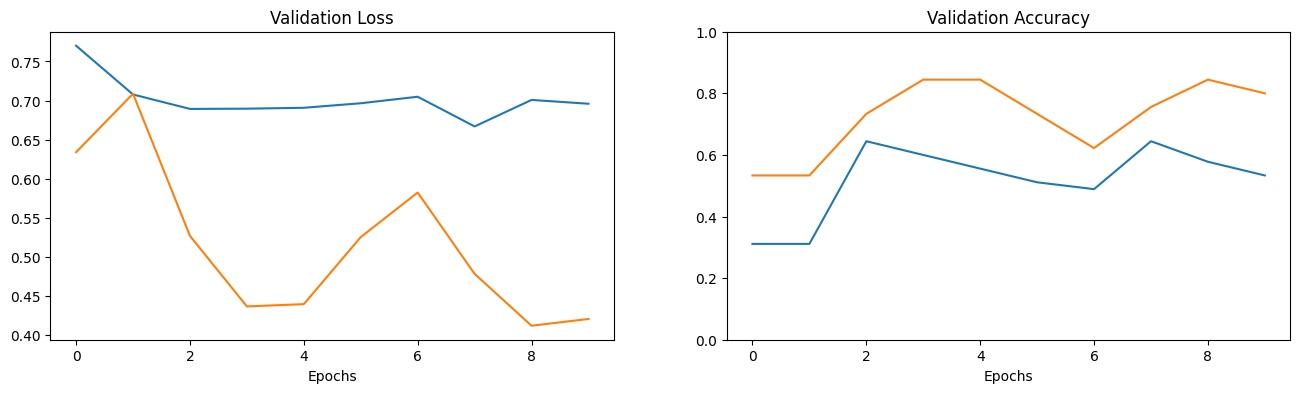

In [28]:
# Criar uma figura com dois subgráficos (1 linha, 2 colunas)
fig = plt.figure(figsize=(16,4))

# Primeiro subgráfico para a perda de validação (val_loss)
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")

# Segundo subgráfico para a acurácia de validação (val_accuracy)
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)

In [29]:
# Avaliando a performance do modelo nos dados de teste
loss, accuracy = model_new.evaluate(
    x_test,
    y_test,
    verbose=0
)

# Exibindo a perda (loss) e a acurácia (accuracy) no conjunto de testes
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Test loss: 0.4321174621582031
Test accuracy: 0.800000011920929


AQUI CRIA UM ALGORÍTMO PARA TESTAR QUALQUER IMAGEM DE CACHORRO OU GATO QUE ESTEJA NA INTERNET. bASTA COLOCAR O ENDEREÇO NA VARIÁVEL image_url

In [30]:
import requests
from PIL import Image
from io import BytesIO

# URL da imagem - Using a different URL that allows access
image_url = 'https://pegadanatural.com.br/wp-content/uploads/3-maneiras-de-cuidar-do-seu-filhote-de-cachorro-com-qualidade.jpg'

# Baixar a imagem da web
response = requests.get(image_url, stream=True)
response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
img = Image.open(BytesIO(response.content))


# Salvar temporariamente a imagem localmente (opcional, para facilitar o debug)
img.save('temp_image.jpg')

# Pré-processar a imagem para fazer a previsão
x = image.img_to_array(img.resize((224, 224)))  # Redimensionar para o tamanho do modelo
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Fazer a previsão
probabilities = model_new.predict(x)

# Obter a classe com maior probabilidade
class_index = np.argmax(probabilities)
confidence = probabilities[0][class_index] * 100
classes = ['Cachorro', 'Gato']

# Exibir o resultado
print(f"A imagem foi classificada como '{classes[class_index]}' "
      f"com {confidence:.2f}% de confiança.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
A imagem foi classificada como 'Cachorro' com 86.74% de confiança.
